In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.models.classification import Classification
from src.models.model_selection import grid_search, feature_selector
from src.models.utils import get_run

In [2]:
# read config
with open('config.yml', 'r') as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

In [3]:
# load data
df = pd.read_csv(config['data_loader']['path'])
display(df.head())

# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,1:-1], df['Class']
    , test_size=config['model_selection']['test_set_size']
    , random_state=123
    , shuffle=True
    )

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


In [ ]:
grid_search(
    X=X_train
    , y=y_train
    , hyper_params=config['model_selection']['algorithms']
    , cv=config['model_selection']['cross_validator']
    , scoring_metric=config['model_selection']['scoring_metric']
)

In [ ]:
# select best algorithm and its hyper-params
best_algorithm, best_hyper_params = get_run(
    experiment_names=['model_evaluation']
    , order_by_metric=True
    , metric_name=config['model_selection']['scoring_metric']
    , num=2
)

# greedy feature selection
"""best_features = feature_selector(
    X=X_train
    , y=y_train
    , algorithm=best_algorithm
    , algorithm_params=best_hyper_params
    , tol=config['model_selection']['tolerance']
    , cv=config['model_selection']['cross_validator']
    , scoring_metric=config['model_selection']['scoring_metric']
)"""

print(
    f'algorithm: {best_algorithm}'
    , f'\nparameters: {best_hyper_params}'
    #, f'\nfeatures: {best_features}'
)
# should feature selection be done before or after model selection?
# should it be trained on different dataset?

algorithm: decision_tree 
parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 10}


In [5]:
# fit best algorithm on most important features of training data 
clf = Classification(algorithm=best_algorithm, **best_hyper_params)
clf.fit(X=X_train.iloc[:,[3,6,8]], y=y_train)
# predict target value for the test set
y_pred = clf.predict(X_test.iloc[:,[3,6,8]])
y_score = clf.score(X_test.iloc[:,[3,6,8]])[:, -1]

In [8]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_clf = TunedThresholdClassifierCV(
    estimator=clf.model
    , scoring="f1"
    , response_method='predict_proba'
    , cv=5
    , refit=True
    , random_state=123
    , store_cv_results=True
)
tuned_clf.fit(X_train, y_train)
print(f"{tuned_clf.best_threshold_=:0.2f}")

tuned_clf.best_threshold_=0.47


Text(0.5, 1.0, 'Objective score as a function of the decision threshold')

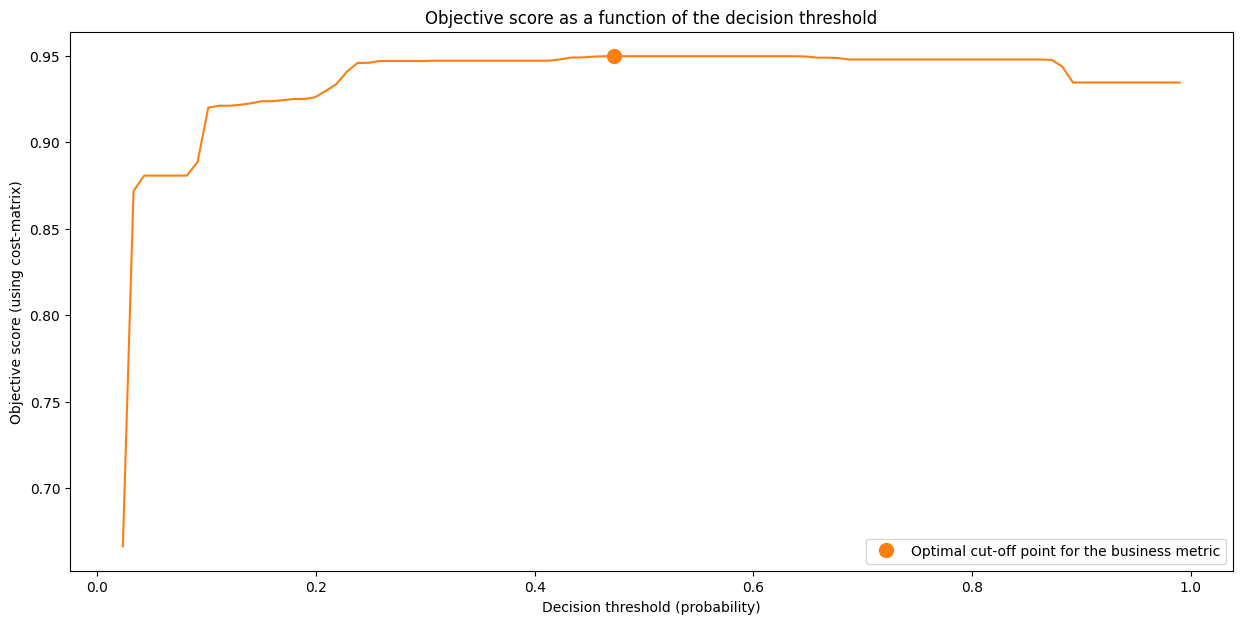

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axs.plot(
        tuned_clf.cv_results_["thresholds"],
        tuned_clf.cv_results_["scores"],
        color="tab:orange",
    )
axs.plot(
    tuned_clf.best_threshold_,
    tuned_clf.best_score_,
    "o",
    markersize=10,
    color="tab:orange",
    label="Optimal cut-off point for the business metric",
)
axs.legend()
axs.set_xlabel("Decision threshold (probability)")
axs.set_ylabel("Objective score (using cost-matrix)")
axs.set_title("Objective score as a function of the decision threshold")
"""
https://medium.com/towards-data-science/tune-in-decision-threshold-optimization-with-scikit-learns-tunedthresholdclassifiercv-7de558a2cf58
https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html#tunedthresholdclassifiercv-no-cv
https://scikit-learn.org/stable/modules/classification_threshold.html
"""

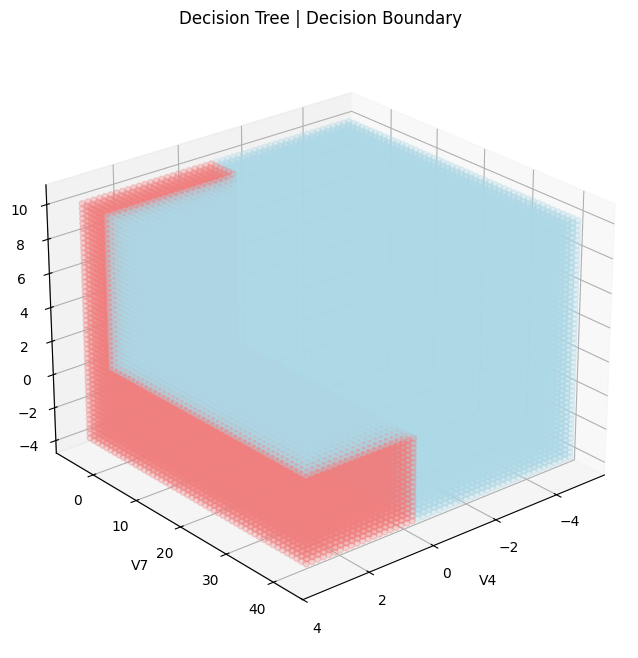

In [6]:
from src.visuals.boundary import plot_boundary

plot_boundary(
    X=X_test.iloc[:,[3,6,8]], y=y_test, clf=clf, azim=50
)

In [ ]:
#pd.DataFrame({'score': y_score, 'label': y_pred}).groupby(by=['label']).describe()
#print(clf.model.decision_path(X_test[best_features[:2]].iloc[:10,:]))

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay, average_precision_score
)

# Print evaluation metrics
print(
    f"""Accuracy : {round(accuracy_score(y_test, y_pred), 5)}
Precision: {round(precision_score(y_test, y_pred), 5)}
Recall   : {round(recall_score(y_test, y_pred), 5)}
F1-Score : {round(f1_score(y_test, y_pred), 5)}"""
)

# plot ROC and PR curves
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
ax[0].plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2, label="Random Guessing")
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC Curve")
ax[0].legend(loc="lower right")
ax[0].grid(True)

# plot PR curve
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap_score = average_precision_score(y_test, y_score)
ax[1].plot(recall, precision, color="green", lw=2, label=f"PR Curve (AP = {ap_score:.3f})")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].set_title("Precision-Recall Curve")
ax[1].legend(loc="lower left")
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
"""
overfitting

https://scikit-learn.org/stable/modules/learning_curve.html
"""